In [31]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import torch

In [44]:
from BRG import CustomGraphDataset
dataset = torch.load('/data/coding/Buchwald/BH-RG.pth')

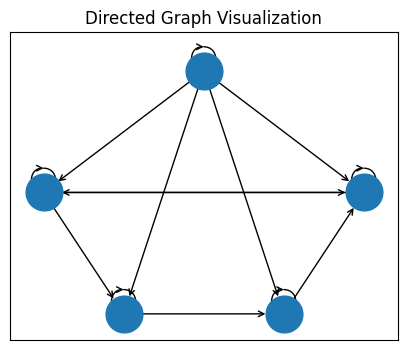

In [45]:
from BRG import visualize_graph_data
visualize_graph_data(dataset[0][0],5, {0: (0, 1),1: (2, 1),2: (0.5, 0),3: (1.5, 0),4: (1, 2)})

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.loader import DataLoader
import random

# GNN Model

In [47]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()
        self.conv1 = GATConv(in_channels, 512, heads=2)  # 确保in_channels已定义
        self.norm1 = nn.BatchNorm1d(1024)
        self.conv2 = GATConv(1024, 256, heads=2)
        self.norm2 = nn.BatchNorm1d(512)

        self.lin1 = nn.Linear(3072, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 256)
        self.lin4 = nn.Linear(256, 128)
        self.lin5 = nn.Linear(128, 1)
        self.bn1 = nn.BatchNorm1d(3072)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(256)

    def get_mask_edge_indices(self, edge_index, batch, mask_edge_positions=None):
        unique_batches, counts = torch.unique(batch[edge_index[0]], return_counts=True)
        mask_indices = []
        start_idx = 0

        for i, count in enumerate(counts):
            # 遍历每个图
            for mask_edge_position in mask_edge_positions:
                if mask_edge_position < count:  # 确保索引不越界
                    mask_indices.append(start_idx + mask_edge_position)
            start_idx += count

        return torch.tensor(mask_indices, dtype=torch.long, device=edge_index.device)

    def mask_edges(self, edge_index, mask_indices):
        masked_edge_index = edge_index[:, mask_indices]
        mask = torch.ones(edge_index.shape[1], dtype=torch.bool, device=edge_index.device)
        mask[mask_indices] = False
        edge_index = edge_index[:, mask]
        return edge_index, masked_edge_index

    def forward(self, data, mask_node=None,  mask_node_feature=None, mask_edge=None):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Masking Edge
        if mask_edge is not None:
            if isinstance(mask_edge, int):
                mask_edge = [mask_edge]  # 如果是单个整数，转换为列表
            mask_indices = self.get_mask_edge_indices(edge_index, batch, mask_edge)
            edge_index, masked_edge_index = self.mask_edges(edge_index, mask_indices)
        
        # Masking Node
        mask = 0
        if mask_node is not None:
            # 计算每个图的起始节点索引
            num_nodes_per_graph = data.num_nodes // len(torch.unique(batch))
            mask_indices = [i * num_nodes_per_graph + mask_node for i in range(len(torch.unique(batch)))]
            mask_indices = torch.tensor(mask_indices, dtype=torch.long, device=x.device)

            if mask_node_feature is not None:
                x[mask_indices, mask_node_feature] = mask
            else:
                x[mask_indices, :] = x[mask_indices, :] * mask

        # 处理卷积层返回的元组
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x1 = F.relu(x)

        x = self.conv2(x1, edge_index)
        x = self.norm2(x)
        x2 = F.relu(x)

        x = torch.cat([x1, x2], 1)

        x_mean = gap(x, batch=batch)
        x_max = gmp(x, batch=batch)
        x = torch.cat([x_mean, x_max], 1)

        x = x.view(x.shape[0], -1)

        x = self.bn1(x)
        x = self.lin1(x)
        x = nn.Dropout(p=0.5)(x)
        x = nn.ReLU()(x)

        x = self.bn2(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)

        x = self.bn3(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)

        x = self.bn4(x)
        x = self.lin4(x)
        x = nn.ReLU()(x)

        x = self.lin5(x)

        return x.squeeze()

#  Model Training

In [48]:
import numpy as np
import csv
import torch
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings

# 设置随机数种子
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# 将数据集分割为训练集和验证集，这里以70%训练，30%验证为例
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 创建DataLoader用于批量训练
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)

# 初始化模型
model = Net(100).to(device)

# 定义损失函数，对于回归任务通常使用均方误差损失(MSEL)
criterion = torch.nn.MSELoss()

# 选择优化器，这里使用Adam，你可以根据需要调整学习率等参数
opti = torch.optim.Adam(model.parameters(), lr=1e-4)


# 忽略特定的警告
warnings.filterwarnings("ignore")

# CSV文件路径
metrics_csv_path = '/data/coding/Buchwald/training_and_validation_metrics.csv'

# 定义CSV的列名
fieldnames = ['Epoch', 'Train_Loss', 'Val_Loss', 'Train_RMSE', 'Val_RMSE', 'Train_R2', 'Val_R2', 'Train_MAE', 'Val_MAE']

#设置训练次数epoch
num_epochs = 2000
train_losses = []  # 用于存储每轮的训练损失
test_losses = []  # 用于存储每轮的测试损失
maes_train = []  # 用于存储每轮训练集的MAE
rmses_train = []  # 用于存储每轮训练集的RMSE
r2s_train = []  # 用于存储每轮训练集的R²
maes_test = []  # 用于存储每轮测试集的MAE
rmses_test = []  # 用于存储每轮测试集的RMSE
r2s_test = []  # 用于存储每轮测试集的R²

# 初始化CSV文件
with open(metrics_csv_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for epoch in range(num_epochs):
    model.train()
    model.to(device)
    running_loss_train = 0.0
    all_preds_train = []
    all_targets_train = []

    # 训练阶段
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opti.zero_grad()
        out = model(inputs)
        loss = criterion(out, labels)
        loss.backward()
        opti.step()
        running_loss_train += loss.item()
        all_preds_train.append(out.detach().cpu().numpy())
        all_targets_train.append(labels.cpu().numpy())

    epoch_loss_train = running_loss_train / len(train_loader)
    all_preds_train = np.concatenate(all_preds_train).flatten()
    all_targets_train = np.concatenate(all_targets_train).flatten()
    
    mae_train = mean_absolute_error(all_targets_train, all_preds_train)
    rmse_train = np.sqrt(mean_squared_error(all_targets_train, all_preds_train))
    r2_train = r2_score(all_targets_train, all_preds_train)

    # 测试阶段
    model.eval()
    with torch.no_grad():
        running_loss_val = 0.0
        all_preds_val = []
        all_targets_val = []

        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            val_loss = criterion(out, labels)
            running_loss_val += val_loss.item()
            all_preds_val.append(out.detach().cpu().numpy())
            all_targets_val.append(labels.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        all_preds_val = np.concatenate(all_preds_val).flatten()
        all_targets_val = np.concatenate(all_targets_val).flatten()
        
        mae_val = mean_absolute_error(all_targets_val, all_preds_val)
        rmse_val = np.sqrt(mean_squared_error(all_preds_val, all_targets_val))
        r2_val = r2_score(all_targets_val, all_preds_val)

        # 记录本轮的指标
        train_losses.append(epoch_loss_train)
        maes_train.append(mae_train)
        rmses_train.append(rmse_train)
        r2s_train.append(r2_train)
        test_losses.append(epoch_loss_val)
        maes_test.append(mae_val)
        rmses_test.append(rmse_val)
        r2s_test.append(r2_val)

    # 写入CSV文件
    with open(metrics_csv_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({
            'Epoch': epoch + 1,
            'Train_Loss': epoch_loss_train,
            'Val_Loss': epoch_loss_val,
            'Train_RMSE': rmse_train,
            'Val_RMSE': rmse_val,
            'Train_R2': r2_train,
            'Val_R2': r2_val,
            'Train_MAE': mae_train,
            'Val_MAE': mae_val
        })

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}, '
          f'Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Train R²: {r2_train:.4f}, Val R²: {r2_val:.4f}, '
          f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}')

Epoch 1/2000, Train Loss: 0.0804, Val Loss: 0.0524, Train RMSE: 0.2838, Val RMSE: 0.2306, Train R²: -0.0864, Val R²: 0.2935, Train MAE: 0.2231, Val MAE: 0.1849
Epoch 2/2000, Train Loss: 0.0584, Val Loss: 0.0445, Train RMSE: 0.2397, Val RMSE: 0.2115, Train R²: 0.2250, Val R²: 0.4058, Train MAE: 0.1918, Val MAE: 0.1662
Epoch 3/2000, Train Loss: 0.0493, Val Loss: 0.0454, Train RMSE: 0.2217, Val RMSE: 0.2127, Train R²: 0.3369, Val R²: 0.3991, Train MAE: 0.1766, Val MAE: 0.1690
Epoch 4/2000, Train Loss: 0.0480, Val Loss: 0.0414, Train RMSE: 0.2181, Val RMSE: 0.2058, Train R²: 0.3580, Val R²: 0.4371, Train MAE: 0.1727, Val MAE: 0.1595
Epoch 5/2000, Train Loss: 0.0459, Val Loss: 0.0408, Train RMSE: 0.2146, Val RMSE: 0.2019, Train R²: 0.3787, Val R²: 0.4582, Train MAE: 0.1689, Val MAE: 0.1598
Epoch 6/2000, Train Loss: 0.0428, Val Loss: 0.0352, Train RMSE: 0.2053, Val RMSE: 0.1912, Train R²: 0.4312, Val R²: 0.5142, Train MAE: 0.1623, Val MAE: 0.1529
Epoch 7/2000, Train Loss: 0.0404, Val Loss: 0

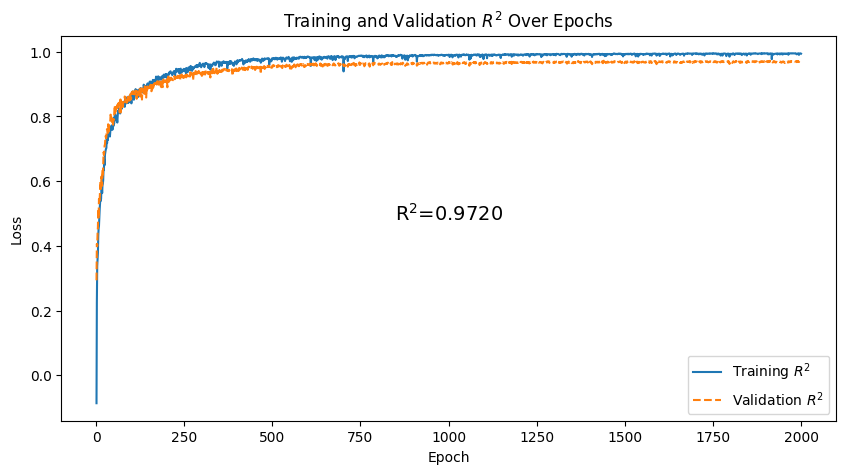

In [49]:
# 训练完成后，绘制训练和验证损失曲线
plot_save_path = '/data/coding/Buchwald/training_and_validation_r2_plot.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), r2s_train, label='Training $R^2$')
plt.plot(range(1, num_epochs + 1), r2s_test, label='Validation $R^2$', linestyle='--')
plt.text(1000, 0.5, 'R$^2$=0.9720', fontsize=14, va='center', ha='center')
plt.title('Training and Validation $R^2$ Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(plot_save_path)  # 保存图表到当前目录
plt.show()  # 显示图表

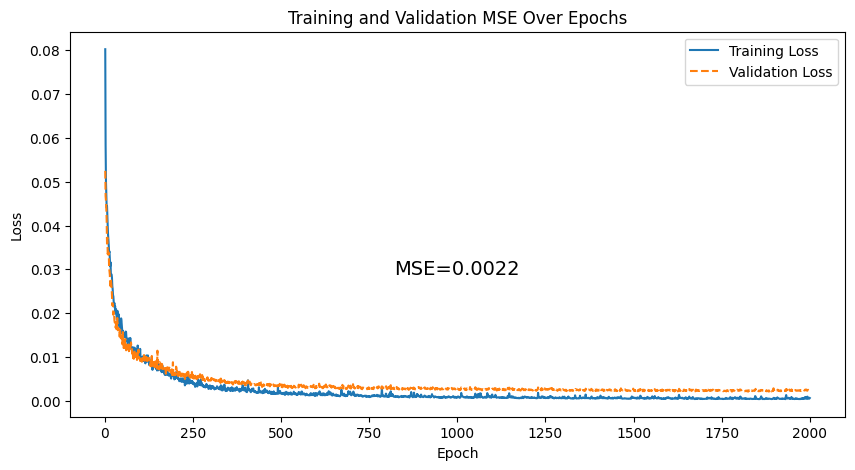

In [23]:
# 训练完成后，绘制训练和验证损失曲线
plot_save_path = '/data/coding/Buchwald/training_and_validation_loss_plot.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss', linestyle='--')
plt.text(1000, 0.03, 'MSE=0.0022', fontsize=14, va='center', ha='center')
plt.title('Training and Validation MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(plot_save_path)  # 保存图表到当前目录
plt.show()  # 显示图表

# Model explanation

In [50]:
dataset = torch.load('/data/coding/Buchwald/BH-RG.pth')
display(dataset[0][0].edge_index)

tensor([[0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4],
        [0, 1, 2, 1, 0, 2, 3, 3, 1, 0, 1, 2, 3, 4]])

### Edge Masking

In [ ]:
from torch_geometric.loader import DataLoader
import torch
import numpy as np

#设置随几数种子确保结果可重复
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 创建数据加载器
dataset_loader = DataLoader(dataset, batch_size=512, shuffle=False)

# 定义要遮蔽的边
mask_edge_list = [[1,4], [2], [6], [8], [9], [10], [11], [12]]
importance_scores = []

for mask_edge in mask_edge_list:
    all_masked_outputs = []
    all_labels = []

    # 模型禁止梯度传播
    with torch.no_grad():
        for data in dataset_loader:
            inputs, labels = data
            masked_output = model(inputs.to(device), mask_edge=mask_edge)
            all_masked_outputs.append(masked_output.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # 合并所有的预测结果和标签
    all_masked_outputs = np.concatenate(all_masked_outputs)
    all_labels = np.concatenate(all_labels)

    # 计算 RMSE
    squared_differences = (all_masked_outputs - all_labels) ** 2
    mse = np.mean(squared_differences)
    importance_score = np.sqrt(mse)
    importance_scores.append(importance_score)
    print(f"Importance Score (RMSE): {importance_score}")

Importance Score (RMSE): 0.16234761476516724
Importance Score (RMSE): 0.03853095322847366
Importance Score (RMSE): 0.05942237004637718
Importance Score (RMSE): 0.0709327831864357
Importance Score (RMSE): 0.07078637927770615
Importance Score (RMSE): 0.06824324280023575
Importance Score (RMSE): 0.05733150616288185
Importance Score (RMSE): 0.07805778086185455


### Node Masking

In [64]:
mask_node_index = range(5)
importance_scores = []

for mask_node in mask_node_index:
    all_masked_outputs = []
    all_labels = []

    # 模型禁止梯度传播
    with torch.no_grad():
        for data in dataset_loader:
            inputs, labels = data
            masked_output = model(inputs.to(device), mask_node=mask_node)
            all_masked_outputs.append(masked_output.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # 合并所有的预测结果和标签
    all_masked_outputs = np.concatenate(all_masked_outputs)
    all_labels = np.concatenate(all_labels)

    # 计算 RMSE
    squared_differences = (all_masked_outputs - all_labels) ** 2
    mse = np.mean(squared_differences)
    importance_score = np.sqrt(mse)
    importance_scores.append(importance_score)
    print(f"Importance Score (RMSE): {importance_score}")

Importance Score (RMSE): 0.21104128658771515
Importance Score (RMSE): 0.19154420495033264
Importance Score (RMSE): 0.09685445576906204
Importance Score (RMSE): 0.13901519775390625
Importance Score (RMSE): 0.19486282765865326


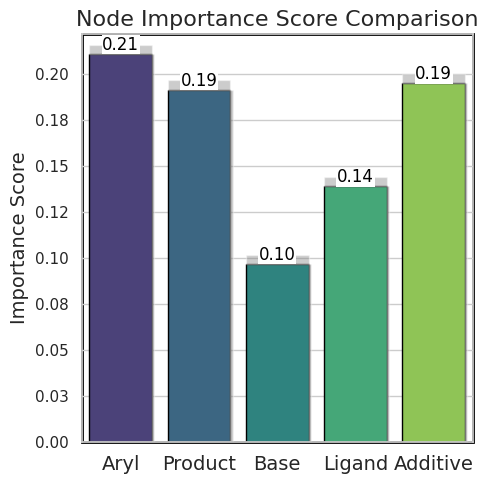

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# 创建数据框
df = pd.DataFrame(columns=['Node', 'Importance'])
df['Node'] = [i for i in range(5)]
df['Importance'] = importance_scores  # 假设 importance_scores 是一个长度为 5 的列表
df['Component'] = ['Aryl', 'Product', 'Base', 'Ligand', 'Additive']

# 设置绘图风格
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))

# 绘制柱状图
ax = sns.barplot(
    x='Node', 
    y='Importance', 
    hue='Component', 
    data=df, 
    palette='viridis', 
    edgecolor='black', 
    legend=False
)

# 添加阴影以增加立体感
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.add_patch(plt.Rectangle((left + width, bottom), 0.03, height, fill=True, facecolor='gray', alpha=0.4))
    ax.add_patch(plt.Rectangle((left, bottom + height), width, 0.005, fill=True, facecolor='gray', alpha=0.4))

# 设置标题和标签
plt.title('Node Importance Score Comparison', fontsize=16)
plt.ylabel('Importance Score', fontsize=14)
plt.xlabel('')  # 隐藏 X 轴标题

# 设置 X 轴的自定义标签
ax.set_xticks(range(len(df)))  # 设置 X 轴刻度位置
ax.set_xticklabels(['Aryl', 'Product', 'Base', 'Ligand', 'Additive'], fontsize=14)  # 设置自定义标签

# 添加数值标签到每个柱子上，并调整文本格式
bars = ax.patches  # 获取所有的柱子
for bar in bars[:len(df)]:  # 遍历所有柱子
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2., 
        height, 
        f'{height:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=12, 
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5)
    )

# 为整个图像添加黑色边框
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(2)

# 格式化 Y 轴刻度，保留小数点后两位
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# 调整布局并显示图形
plt.tight_layout()
plt.show()

### Node Features Masking

In [110]:
from tqdm import tqdm

mask_node_index = 4
mask_node_features = range(100)
importance_scores = []

for mask_node_feature in tqdm(mask_node_features):
    all_masked_outputs = []
    all_labels = []

    # 模型禁止梯度传播
    with torch.no_grad():
        for data in dataset_loader:
            inputs, labels = data
            masked_output = model(inputs.to(device), mask_node=mask_node_index, mask_node_feature=mask_node_feature)
            all_masked_outputs.append(masked_output.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # 合并所有的预测结果和标签
    all_masked_outputs = np.concatenate(all_masked_outputs)
    all_labels = np.concatenate(all_labels)

    # 计算 RMSE
    squared_differences = (all_masked_outputs - all_labels) ** 2
    mse = np.mean(squared_differences)
    importance_score = np.sqrt(mse)
    importance_scores.append(importance_score)

print('Node Features Masking Finished')

100%|██████████| 100/100 [00:17<00:00,  5.61it/s]

Node Features Masking Finished
